In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
import pandas as pd
from transformers import CLIPProcessor, CLIPModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Device: cuda


In [2]:
import numpy as np
import cv2
import pandas as pd
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split


import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import time
import itertools
import torch.optim as optim
import torch.nn.functional as F
import math

from transformers import DistilBertTokenizer, DistilBertModel, AutoTokenizer
from transformers import GPT2Tokenizer, GPT2Model

# Vérification du dispositif disponible pour PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
df_projections = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
df_reports = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

In [4]:
df_reports


,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.
...,...,...,...,...,...,...,...,...
3846,3995,Lung/hyperdistention/mild;Diaphragm/bilateral/...,Lung;Diaphragm;Cicatrix;Pulmonary Atelectasis;...,Xray Chest PA and Lateral,"Nausea, vomiting x2 weeks. Dialysis patient.","XXXX, XXXX.",The cardiomediastinal silhouette and pulmonary...,1. Interval resolution of bibasilar airspace d...
3847,3996,Spine/degenerative,Spine,Xray Chest PA and Lateral,NaN,None.,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...
3848,3997,Opacity/lung/upper lobe/right/round/small;Gran...,Opacity;Granuloma,PA and lateral views of the chest.,XXXX-year-old male with positive PPD.,None available.,"Heart size within normal limits. Small, nodula...","No acute findings, no evidence for active TB."
3849,3998,normal,normal,"PA and lateral chest XXXX, XXXX XXXX comparis...",tuberculosis positive PPD,NaN,NaN,Heart size is normal and the lungs are clear.


In [5]:



images_captions_df = pd.DataFrame({
    'image': [],
    'context_summary': [],  # Cột Ngữ cảnh Tóm tắt 
    'caption': [],          
    'number_of_words': []
})

for i in range(len(df_projections)):
    uid = df_projections.iloc[i]['uid']
    image = df_projections.iloc[i]['filename']
    index = df_reports.loc[df_reports['uid'] == uid]
    
    if not index.empty:    
        index = index.index[0]
        
        caption = df_reports.iloc[index]['findings']
        
        indication = df_reports.iloc[index]['indication']
        impression = df_reports.iloc[index]['impression']
        
        context_summary = f"Indication: {str(indication)}. Conclusion: {str(impression)}"
        
        if pd.isna(caption) or type(caption) == float:
            continue
            
        number_of_words = len(str(caption).split())

        new_row = pd.DataFrame([{
            'image': image, 
            'context_summary': context_summary,
            'caption': caption, 
            'number_of_words': number_of_words
        }])
        
        images_captions_df = pd.concat([images_captions_df, new_row], ignore_index=True)

images_captions_df["number_of_words"] = images_captions_df["caption"].apply(lambda text: len(str(text).split()))
images_captions_df['number_of_words'] = images_captions_df['number_of_words'].astype(int)

images_captions_df.head()

,image,context_summary,caption,number_of_words
0,1_IM-0001-4001.dcm.png,Indication: Positive TB test. Conclusion: Norm...,The cardiac silhouette and mediastinum size ar...,34
1,1_IM-0001-3001.dcm.png,Indication: Positive TB test. Conclusion: Norm...,The cardiac silhouette and mediastinum size ar...,34
2,2_IM-0652-1001.dcm.png,Indication: Preop bariatric surgery.. Conclusi...,Borderline cardiomegaly. Midline sternotomy XX...,14
3,2_IM-0652-2001.dcm.png,Indication: Preop bariatric surgery.. Conclusi...,Borderline cardiomegaly. Midline sternotomy XX...,14
4,4_IM-2050-1001.dcm.png,Indication: XXXX-year-old XXXX with XXXX.. Con...,There are diffuse bilateral interstitial and a...,64


In [6]:
image_folder = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized"

for img_name in images_captions_df['image'].head(5):
    img_path = os.path.join(image_folder, img_name)
    print(img_path, os.path.exists(img_path))


/kaggle/input/chest-xrays-indiana-university/images/images_normalized/1_IM-0001-4001.dcm.png True
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/1_IM-0001-3001.dcm.png True
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/2_IM-0652-1001.dcm.png True
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/2_IM-0652-2001.dcm.png True
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/4_IM-2050-1001.dcm.png True


In [7]:
image_folder = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'
image_filenames = images_captions_df.image.values


train_captions,test_captions =train_test_split(images_captions_df, test_size = 0.2)
print(train_captions.shape)
print (test_captions.shape)

(5175, 4)
(1294, 4)


In [8]:
train_captions

,image,context_summary,caption,number_of_words
5946,3673_IM-1828-1001.dcm.png,Indication: XXXX dyspnea. Conclusion: Left mid...,The heart is normal in size. The mediastinal c...,61
4703,2929_IM-1331-1001.dcm.png,Indication: XXXX. Conclusion: No acute disease.,The heart is top normal in size. The mediastin...,28
6403,3962_IM-2027-2001.dcm.png,Indication: XXXX. Conclusion: Normal chest,Heart size normal. Lungs are clear. XXXX are n...,18
295,183_IM-0537-1002.dcm.png,"Indication: XXXX-year-old male, XXXX.. Conclus...",Heart size within normal limits. There are low...,43
3868,2389_IM-0944-3001.dcm.png,Indication: XXXX and XXXX. Chest pain. Vomitin...,2 images. Heart size and pulmonary vascular en...,30
...,...,...,...,...
3318,2033_IM-0678-2001.dcm.png,Indication: Chest pain.. Conclusion: No acute ...,The cardiac silhouette is near upper limits of...,54
3194,1952_IM-0620-3001.dcm.png,Indication: The patient is a XXXX-year-old XXX...,The trachea is midline. The cardiomediastinal ...,47
289,179_IM-0514-2001.dcm.png,Indication: Dyspnea and XXXX. Conclusion: No a...,"No airspace disease, effusion or noncalcified ...",22
1293,785_IM-2325-1001.dcm.png,Indication: Chest pain.. Conclusion: No acute ...,The cardiomediastinal silhouette and pulmonary...,30


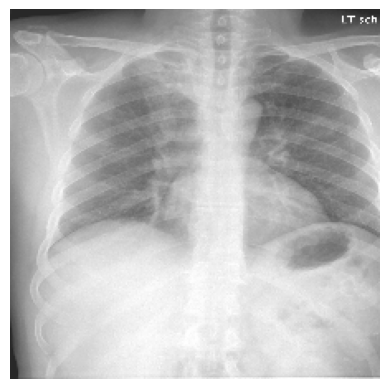

(224, 224, 3)


In [9]:
batch_size = 16
image_size = 224

def preprocess_image(image_path, image_size):
    """
    Loads and preprocesses an image.
    
    Args:
        image_path (str): Path to the image to load.
        target_size (int): The new size of the images (assumes square images).
    
    Returns:
        numpy.ndarray: The preprocessed image.
    """
    # Load the image using OpenCV
    img = cv2.imread(image_path)
    # Resize the image
    img = cv2.resize(img, (image_size, image_size))
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def display_image(image_np):
    """
    Displays an image.
    
    Args:
        image_np (numpy.ndarray): The image to display.
    """
    plt.imshow(image_np)
    plt.axis('off')  # Hide axis labels
    plt.show()
image = preprocess_image("/kaggle/input/chest-xrays-indiana-university/images/images_normalized/1000_IM-0003-1001.dcm.png",image_size)
display_image (image)
print(image.shape)

In [10]:
# Get the number of available processors
num_processors = os.cpu_count()

class ImageTextDataset(Dataset):
    def __init__(self, image_filenames, captions, context_summary, image_size=image_size):
        """
        Initializes the dataset.
        
        Args:
            image_filenames (list): List of image file paths.
            captions (list): List of corresponding captions.
            image_size (int): Target size for the images.
        """
        self.image_filenames = image_filenames
        self.captions = captions
        self.context_summary = context_summary
        self.image_size = image_size
        self.transform = transforms.Compose([transforms.ToTensor()])
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        image_path = f"/kaggle/input/chest-xrays-indiana-university/images/images_normalized/{self.image_filenames[idx]}"
        image = preprocess_image(image_path, self.image_size)
        image = self.transform(image)
        context_summary = self.context_summary[idx]
        caption = self.captions[idx]

        return image, context_summary, caption


In [11]:
# Create dataset instances
train_dataset = ImageTextDataset(train_captions.image.values, train_captions.caption.values, train_captions.context_summary.values) #,image_size)
test_dataset = ImageTextDataset(test_captions.image.values, test_captions.caption.values, test_captions.context_summary.values ) # ,image_size)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(train_dataset. __getitem__(0)[0].shape)

torch.Size([3, 224, 224])


In [12]:
print(f"train_dataset: {len(train_dataset)}")

image, summary, caption = train_dataset[0]
print(f" image: {type(image)}")
print(f"summary : {summary}")
print(f"Caption: {caption}")


train_dataset: 5175
 image: <class 'torch.Tensor'>
summary : Indication: XXXX dyspnea. Conclusion: Left midlung opacity may be secondary to acute infectious process or developing mass lesion. Followup to resolution is recommended.
Caption: The heart is normal in size. The mediastinal contours are stable. Aortic calcifications are noted. There are small calcified lymph XXXX. Emphysema and chronic changes are identified. There is XXXX opacity in the left perihilar upper lobe. There is questionable XXXX extension to the pleural surface. This may represent acute infiltrate or developing density. There is no pleural effusion or pneumothorax.


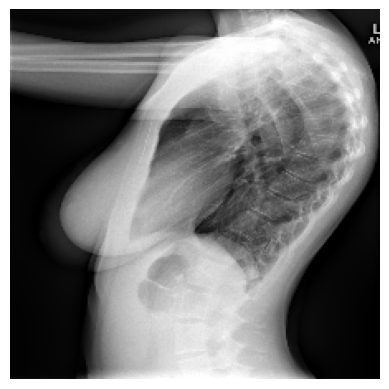

summary: Indication: Chest pain with shortness of breath. Conclusion: 1. No acute pulmonary abnormality.


caption: The lungs and pleural spaces show no acute abnormality. Heart size and pulmonary vascularity within normal limits.




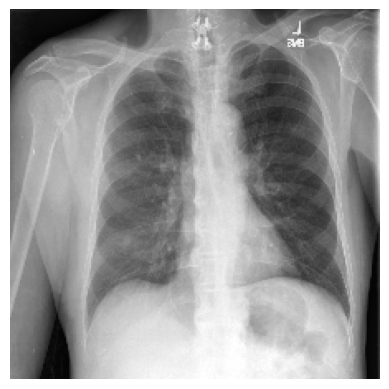

summary: Indication: XXXX-year-old male with XXXX and possible TB exposure.. Conclusion: Negative for acute cardiopulmonary disease.


caption: Stable appearance of lower cervical fusion XXXX. Heart size normal. No pneumothorax or pleural effusion. No focal airspace disease. Calcified nodules consistent with chronic granulomatous disease. Bony structures appear intact. DISH of the thoracic spine.




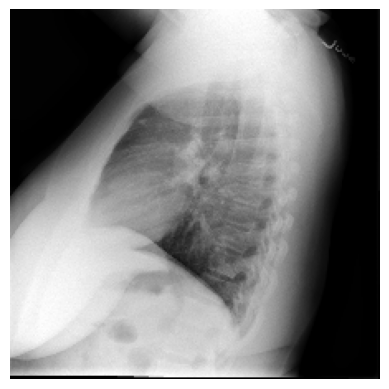

summary: Indication: XXXX. Conclusion: No active disease.


caption: The heart and lungs have XXXX XXXX in the interval. Both lungs are clear and expanded. Heart and mediastinum normal.




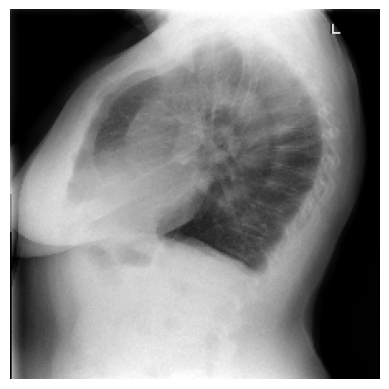

summary: Indication: in a long XXXX XXXX. Conclusion: XXXX change COPD. No acute findings.


caption: Lungs are hyperexpanded. No infiltrates or masses in the lungs. Heart size normal.




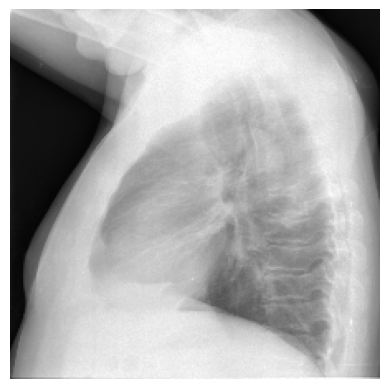

summary: Indication: XXXX-year-old male with chest pain.. Conclusion: No acute cardiopulmonary abnormality..


caption: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.




In [13]:
images_batch, summary_batch, caption_batch = next(iter(train_dataloader))

for i in range(5):  # Display the first 5 images and captions
    image_to_display = images_batch[i].permute(1, 2, 0).numpy()
    summary_to_display = summary_batch[i]
    caption_to_display = caption_batch[i]
    display_image(image_to_display)
    print(f"summary: {summary_to_display}\n\n")
    print(f"caption: {caption_to_display}\n\n")
 


In [14]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import CLIPModel, CLIPProcessor, AutoModel, AutoTokenizer

class ImageSummaryToCaptionCLIP(nn.Module):
    def __init__(self, 
                 clip_model_name="openai/clip-vit-base-patch32",
                 text_model_name="bert-base-uncased"):
        super().__init__()
        # CLIP image encoder
        self.clip = CLIPModel.from_pretrained(clip_model_name)
        self.processor = CLIPProcessor.from_pretrained(clip_model_name)

        # Text encoder (BERT)
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        self.text_tokenizer = AutoTokenizer.from_pretrained(text_model_name)

        # Projection heads
        clip_dim = self.clip.config.projection_dim
        text_dim = self.text_encoder.config.hidden_size
        self.query_proj = nn.Linear(clip_dim + text_dim, clip_dim)
        self.caption_proj = nn.Linear(text_dim, clip_dim)

    def encode_image(self, image_tensor):
        # image_tensor: [B, 3, 224, 224]
        image_features = self.clip.get_image_features(image_tensor)
        return F.normalize(image_features, dim=-1)

    def encode_text(self, texts):
        tokens = self.text_tokenizer(
            texts, return_tensors="pt", padding=True, truncation=True
        ).to(next(self.parameters()).device)
        outputs = self.text_encoder(**tokens)
        emb = outputs.last_hidden_state[:, 0, :]  # [CLS]
        return F.normalize(emb, dim=-1)

    def encode_query(self, images, summaries):
        img_emb = self.encode_image(images)
        txt_emb = self.encode_text(summaries)
        fused = torch.cat([img_emb, txt_emb], dim=-1)
        q_emb = self.query_proj(fused)
        return F.normalize(q_emb, dim=-1)

    def encode_caption(self, captions):
        cap_emb = self.encode_text(captions)
        cap_emb = self.caption_proj(cap_emb)
        return F.normalize(cap_emb, dim=-1)


In [16]:
def clip_loss(query_emb, caption_emb, temperature=0.1):
    logits = query_emb @ caption_emb.T / temperature
    labels = torch.arange(len(query_emb)).to(query_emb.device)
    loss_i = F.cross_entropy(logits, labels)
    loss_t = F.cross_entropy(logits.T, labels)
    return (loss_i + loss_t) / 2


In [17]:
!pip install accelerate==0.33.0
!pip install -U transformers==4.45.2 huggingface_hub==0.25.2 --quiet



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 84.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.9 MB/s eta 0:00:00:00:01


In [18]:
from transformers import CLIPModel, CLIPProcessor

model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)
print(" CLIP model loaded successfully!")


2025-11-07 14:03:03.585682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762524183.608874     173 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762524183.615764     173 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  # is changed.


 CLIP model loaded successfully!


In [19]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ImageSummaryToCaptionCLIP().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

for epoch in range(20):  # thử 3 epoch đầu
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader):
        images, summaries, captions = batch  
        images = images.to(device)


        # images = batch["image"].to(device)
        # summaries = batch["summary"]
        # captions = batch["caption"]

        q_emb = model.encode_query(images, summaries)
        c_emb = model.encode_caption(captions)

        loss = clip_loss(q_emb, c_emb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}: loss={total_loss/len(train_dataloader):.4f}")


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 324/324 [07:07<00:00,  1.32s/it]


Epoch 1: loss=2.1617


100%|██████████| 324/324 [06:01<00:00,  1.12s/it]


Epoch 2: loss=1.3854


100%|██████████| 324/324 [06:01<00:00,  1.12s/it]


Epoch 3: loss=0.9702


100%|██████████| 324/324 [06:01<00:00,  1.12s/it]


Epoch 4: loss=0.7290


100%|██████████| 324/324 [06:03<00:00,  1.12s/it]


Epoch 5: loss=0.5663


100%|██████████| 324/324 [06:03<00:00,  1.12s/it]


Epoch 6: loss=0.4644


100%|██████████| 324/324 [06:02<00:00,  1.12s/it]


Epoch 7: loss=0.3911


100%|██████████| 324/324 [06:02<00:00,  1.12s/it]


Epoch 8: loss=0.3359


100%|██████████| 324/324 [06:00<00:00,  1.11s/it]


Epoch 9: loss=0.2992


100%|██████████| 324/324 [05:56<00:00,  1.10s/it]


Epoch 10: loss=0.2703


100%|██████████| 324/324 [05:59<00:00,  1.11s/it]


Epoch 11: loss=0.2416


100%|██████████| 324/324 [05:57<00:00,  1.10s/it]


Epoch 12: loss=0.2334


100%|██████████| 324/324 [05:59<00:00,  1.11s/it]


Epoch 13: loss=0.2026


100%|██████████| 324/324 [05:58<00:00,  1.11s/it]


Epoch 14: loss=0.1949


100%|██████████| 324/324 [05:58<00:00,  1.11s/it]


Epoch 15: loss=0.1784


100%|██████████| 324/324 [05:58<00:00,  1.11s/it]


Epoch 16: loss=0.1694


100%|██████████| 324/324 [05:58<00:00,  1.11s/it]


Epoch 17: loss=0.1561


100%|██████████| 324/324 [05:59<00:00,  1.11s/it]


Epoch 18: loss=0.1552


100%|██████████| 324/324 [06:00<00:00,  1.11s/it]


Epoch 19: loss=0.1436


100%|██████████| 324/324 [05:59<00:00,  1.11s/it]

Epoch 20: loss=0.1358


In [21]:
# Sau vòng for epoch
torch.save(model.state_dict(), "image_summary_clip_model.pt")
print("Model saved to image_summary_clip_model.pt")


✅ Model saved to image_summary_clip_model.pt


In [22]:
model.eval()
with torch.no_grad():
    # Encode all captions
    all_caps = [cap for _, _, cap in test_dataset]
    cap_embs = []
    for i in range(0, len(all_caps), 32):
        cap_embs.append(model.encode_caption(all_caps[i:i+32]))
    cap_embs = torch.cat(cap_embs, dim=0)

    # Query: 1 ảnh + summary
    q_img, q_sum, _ = test_dataset[0] 
    q_img = q_img.unsqueeze(0).to(device)
    q_emb = model.encode_query(q_img, [q_sum])

    # Similarity retrieval
    sims = (q_emb @ cap_embs.T).squeeze(0)
    topk = torch.topk(sims, k=5)

    print("\nQuery summary:", q_sum)
    print("Top retrieved captions:")
    for i, idx in enumerate(topk.indices):
        print(f"{i+1}. {all_caps[idx]} (score={topk.values[i]:.3f})")




Query summary: Indication: MVA with back pain. Conclusion: Chest. No acute radiographic cardiopulmonary process. Thoracic spine. Mild degenerative change without acute bony abnormality. Lumbar spine. Mild degenerative change without acute bony abnormality.
Top retrieved captions:
1. Chest: The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. Thoracic spine: Mild dextro curvature the upper thoracic spine. Evaluation of the upper thoracic bodies is limited secondary to osseous overlap. Vertebral body XXXX and disc spaces are maintained. Mild degenerative endplate changes. Lumbar spine: There are 5 nonrib-bearing lumbar type vertebral bodies. Alignment is within normal limits. Vertebral body XXXX and disc spaces are maintained. Mild degenerative change without acute displaced fracture or dislocation. Moderate amount of stool.. (score=0.868)
2. Chest. A 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ImageSummaryToCaptionCLIP().to(device)

checkpoint_path = "image_summary_clip_model.pt"  # đường dẫn file .pth
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

print("Model loaded successfully and ready for evaluation.")


In [23]:
with torch.no_grad():
    # Encode toàn bộ caption trong tập test
    all_caps = [cap for _, _, cap in test_dataset]
    cap_embs = []
    for i in range(0, len(all_caps), 32):
        batch_caps = all_caps[i:i+32]
        cap_embs.append(model.encode_caption(batch_caps))
    cap_embs = torch.cat(cap_embs, dim=0)

    # Lấy 1 mẫu query: ảnh + summary + caption ground truth
    q_img, q_sum, q_gt = test_dataset[0]
    q_img = q_img.unsqueeze(0).to(device)

    # Encode query
    q_emb = model.encode_query(q_img, [q_sum])

    # Tính similarity với tất cả caption
    sims = (q_emb @ cap_embs.T).squeeze(0)
    topk = torch.topk(sims, k=5)

    print("="*80)
    print("Query Summary:")
    print(q_sum)
    print("\n Ground Truth Caption:")
    print(q_gt)
    print("\n Top Retrieved Captions:")
    for i, idx in enumerate(topk.indices):
        print(f"{i+1}. {all_caps[idx]} (score={topk.values[i]:.3f})")
    print("="*80)


Query Summary:
Indication: MVA with back pain. Conclusion: Chest. No acute radiographic cardiopulmonary process. Thoracic spine. Mild degenerative change without acute bony abnormality. Lumbar spine. Mild degenerative change without acute bony abnormality.

 Ground Truth Caption:
Chest: The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. Thoracic spine: Mild dextro curvature the upper thoracic spine. Evaluation of the upper thoracic bodies is limited secondary to osseous overlap. Vertebral body XXXX and disc spaces are maintained. Mild degenerative endplate changes. Lumbar spine: There are 5 nonrib-bearing lumbar type vertebral bodies. Alignment is within normal limits. Vertebral body XXXX and disc spaces are maintained. Mild degenerative change without acute displaced fracture or dislocation. Moderate amount of stool..

 Top Retrieved Captions:
1. C